# 特征工程

## 1.内容介绍

- 1.异常处理：
    - 通过箱形图（或3-sigma）分析删除异常值
    - box-cox转换（处理有偏分布）
    - 长尾截断
- 2.特征归一化/标准化
    - 标准化（转换为标准正态分布）
    - 归一化（转换到【0，1】区间）
    - 针对幂律分布，可以采用公式log((1+x)/(1+median))
- 3.数据分桶：
    - 等频分桶
    - 等距分桶
    - best-ks分桶（类似利用基尼指数进行二分类）
    - 卡方分桶
- 4.缺失值处理：
    - 不处理（针对类似xgboost等数模型）
    - 删除（缺失数据太多）
    - 插值补全，包括均值/中位数/众数/建模预测/多重插补/压缩感知补全/矩阵补全等
    - 分箱，缺失值一个箱
- 5.特征构造：
    - 构造统计量特征，报告计数，求和，比例，标准差等
    - 时间特征，包括相对时间和绝对时间，节假日，双休日
    - 地理信息，包括分箱，分布编码等方法
    - 非线性变换，包括log/平方/根号
    - 特征相同，特征交叉
    - 仁者见仁，智者见智
- 6.特征筛选
    - 过滤式(filter)：先对数据进行特征选择，然后在训练学习器，常见的方法有Relief/方差选择器/相关系数法/卡方检验法/互信息法
    - 包裹法(wrapper)：直接把最终要使用的学习器的性能作为特征子集的评价准则，常见方法有LVM(Las Vegas Wrapper)
    - 嵌入式(embedding):结合过滤式和包裹式，学习器训练过程中自动进行了特征选择，常见的有lasso回归
- 7.降维
    - PCA/LDA/ICA
    - 特征选择也是一种降维


## 代码部分

### 0.导入数据

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
Train_data=pd.read_csv('./used_car_train_20200313.csv',sep=' ')
Test_data=pd.read_csv('./used_car_testB_20200421.csv',sep=' ')
print(Train_data.shape)
print(Test_data.shape)

(150000, 31)
(50000, 30)


In [3]:
Train_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [4]:
Train_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14'],
      dtype='object')

### 1)删除异常值

In [5]:
def outliers_proc(data,col_name,scale=3):
    '''
    用于清洗异常值，默认用box_plot(scale=3)进行清洗
    ：param data:接收pandas数据格式
    ：param col_name:pandas 列名
    ：param scale:尺度
    ：return
    '''
    def box_plot_outliers(data_ser,box_scale):
        '''
        利用箱形图去除异常值
        ：param data_ser:接收 pandas.Series 数据格式
        ：param box_scale:箱箱形图尺度
        ：return
        '''
        iqr=box_scale*(data_ser.quantile(0.75)-data_ser.quantile(0.25))
        #3/4位数-1/4位数
        val_low=data_ser.quantile(0.25)-iqr
        val_up=data_ser.quantile(0.75)+iqr
        #去掉小于val_low或者大于val_up的值所在的行
        rule_low=(data_ser<val_low)
        rule_up=(data_ser>val_up)
        return (rule_low,rule_up),(val_low,val_up)
    
    data_n=data.copy()
    data_series=data_n[col_name]
    rule,value=box_plot_outliers(data_series,box_scale=scale)
    index=np.arange(data_series.shape[0])[rule[0] | rule[1]]
    print('Delete number is:{}'.format(len(index)))
    data_n=data_n.drop(index)
    data_n.reset_index(drop=True,inplace=True)
    print('Now column number is:{}'.format(data_n.shape[0]))
    index_low=np.arange(data_series.shape[0])[rule[0]]
    outliers=data_series.iloc[index_low]
    print('Description of data less than the lower bound is:')
    print(pd.Series(outliers).describe())
    index_up=np.arange(data_series.shape[0])[rule[1]]
    outliers=data_series.iloc[index_up]
    print('Description of data larger than the upper bound is:')
    print(pd.Series(outliers).describe())
    
    fig,ax=plt.subplots(1,2,figsize=(10,7))
    sns.boxplot(y=data[col_name],data=data,palette='Set1',ax=ax[0])
    sns.boxplot(y=data_n[col_name],data=data_n,palette='Set1',ax=ax[1])
    return data_n


Delete number is:963
Now column number is:149037
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: power, dtype: float64
Description of data larger than the upper bound is:
count      963.000000
mean       846.836968
std       1929.418081
min        376.000000
25%        400.000000
50%        436.000000
75%        514.000000
max      19312.000000
Name: power, dtype: float64


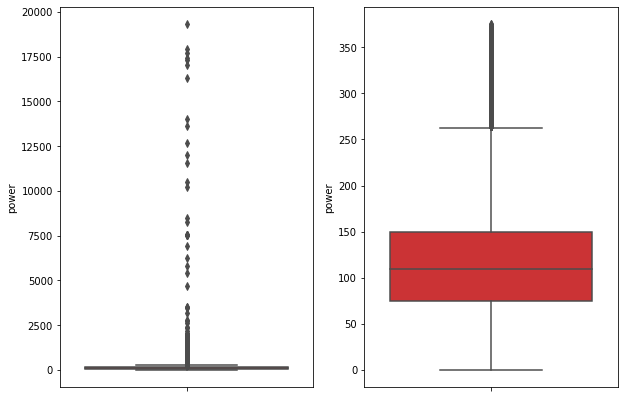

In [6]:
#可以删掉一些异常数据，
#但是test的数据不能删
Train_data=outliers_proc(Train_data,'power',scale=3)
#删除前的/删除后的

### 2)特征构造

In [7]:
#训练集和测试集放在一起，方便构造特征
Train_data['train']=1
Train_data['train']=0
data=pd.concat([Train_data,Test_data],ignore_index=True)


In [8]:
# 使用时间：data['creatDate']-data['regDate'],反应汽车使用时间，一般来说价格与使用时间成反比
# 不过要注意，数据里有时间出错的格式，所以我们需要errors='coerce'
data['used_time']=(pd.to_datetime(data['creatDate'],format='%Y%m%d',errors='coerce')-
                  pd.to_datetime(data['regDate'],format='%Y%m%d',errors='coerce')).dt.days


In [9]:
# 看一下空数据，有15k个样本的时间是有问题的，我们可以选择删除，也可以选择放着
# 但不建议删除，因为删除缺失数据占总样本量过大，7.5%
# 可以先放着，xgboost之类的决策树，其本身就能处理缺失值，所以可以不用管
data['used_time'].isnull().sum()

15054

In [10]:
# 从邮箱中提取城市信息，相当于加入了先验知识
data['city']=data['regionCode'].apply(lambda x:str(x)[:-3])
data=data

In [11]:
# 计算某品牌的销售统计量，同学们还可以计算其他特征的统计量
# 这里要以train的数据计算统计量
Train_gb=Train_data.groupby('brand')
all_info={}
for kind,kind_data in Train_gb:
    info={}
    kind_data=kind_data[kind_data['price']>0]
    info['brand_amount']=len(kind_data)
    info['brand_price_max']=kind_data.price.max()
    info['brand_price_median']=kind_data.price.median()
    info['brand_price_min']=kind_data.price.min()
    info['brand_price_sum']=kind_data.price.sum()
    info['brand_price_std']=kind_data.price.std()
    info['brand_price_average']=round(kind_data.price.sum()/(len(kind_data)+1),2)
    all_info[kind]=info
brand_fe=pd.DataFrame(all_info).T.reset_index().rename(columns={'index':'brand'})
data=data.merge(brand_fe,how='left',on='brand')
    

In [12]:
# 数据分桶 以power为例，。。缺失值也进桶
# one-hot编码的优点有
# 1.离散后稀疏向量内积乘法运算速度更快，计算结果也方便存储，容易扩展
# 2.离散后的特征对异常值更具鲁棒性，如age>30 为 1 否则为 0，对于年龄为200的也不会对模型造成很大的干扰
# 3.LR属于广义线性模型，表达能力有限，经过离散化后，每个变量有单独的权重，这相当于引入了非线性，neng
# 4.离散后特征可以进行特征交叉，表达能力有限，由M+N个变量变成M*N个变量，进一步引入非线性，提升了表达能力
# 5.特征离散后模型更稳定，如用户年龄区间，不会因为用户年龄长了一岁就变化

#还有其他原因，LightGBM 在改进XGBoost时就增加了数据分桶，增强了模型的泛化性

bin=[i*10 for i in range(31)]
data['power_bin']=pd.cut(data['power'],bin,labels=False)
data[['power_bin','power']].head()

,power_bin,power
0,5.0,60
1,NaN,0
2,16.0,163
3,19.0,193
4,6.0,68


In [13]:
# 删除不需要的数据
data=data.drop(['creatDate','regDate','regionCode'],axis=1)

In [14]:
print(data.shape)
data.columns

(199037, 39)


Index(['SaleID', 'name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox',
       'power', 'kilometer', 'notRepairedDamage', 'seller', 'offerType',
       'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8',
       'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'train', 'used_time',
       'city', 'brand_amount', 'brand_price_max', 'brand_price_median',
       'brand_price_min', 'brand_price_sum', 'brand_price_std',
       'brand_price_average', 'power_bin'],
      dtype='object')

In [15]:
# 目前的数据已经可以给树模型使用了，所以导出
# data.to_csv('data_for_tree.csv',index=0)

<AxesSubplot:ylabel='Frequency'>

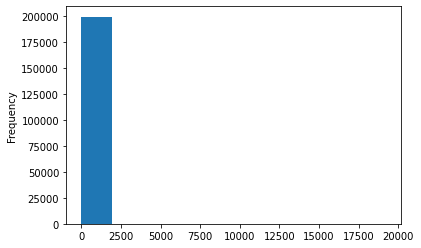

In [16]:
# 可以再构造一份特征给LR NN之类的模型用
# 之所以分开构造是因为 不同模型对数据集的要求不同
# 看数据分布：
data['power'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

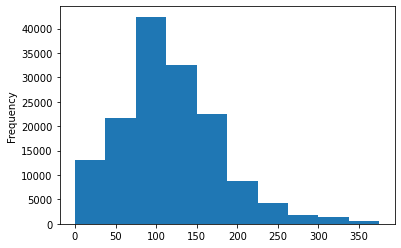

In [17]:
# 前面已经对train进行异常值处理了，但是还有这么多奇怪的分布是因为test中的power异常值
# 观察train数据中power的分布
Train_data['power'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

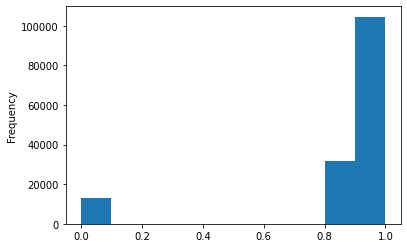

In [41]:
# 对其取log,再做归一化
# 只能对训练集做归一化
from sklearn import preprocessing
min_max_scaler=preprocessing.MinMaxScaler()
Train_data['power']=np.log(Train_data['power']+1)#进行log变换
Train_data['power']=((Train_data['power']-np.min(Train_data['power']))/(np.max(Train_data['power'])-np.min(Train_data['power'])))
Train_data['power'].plot.hist()


<AxesSubplot:ylabel='Frequency'>

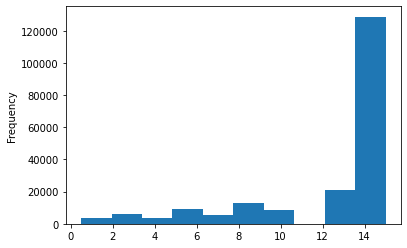

In [19]:
# kw 的比较正常，
data['kilometer'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

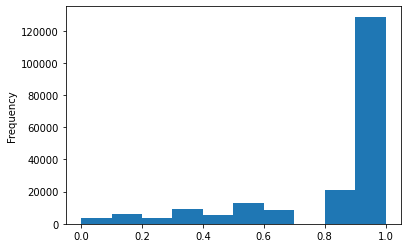

In [20]:
# 可以直接做归一化
data['kilometer']=((data['kilometer']-np.min(data['kilometer']))/
                  (np.max(data['kilometer'])-np.min(data['kilometer'])))
data['kilometer'].plot.hist()


In [24]:
# 除此之外，还有我们刚刚构造的统计量特征
# 'brand_amount','brand_price_average','brand_price_max'
# 'brand_price_median','brand_price_min','brand_price_std'
# 'brand_price_sum'
# 这里不再一一举例分析，直接做变换
def max_min(x):
    return (x-np.min(x))/(np.max()-np.min())

data['brand_amount']=((data['brand_amount']-np.min(data['brand_amount']))/
                     (np.max(data['brand_amount'])-np.min(data['brand_amount'])))
data['brand_price_average']=((data['brand_price_average']-np.min(data['brand_price_average']))/
                            (np.max(data['brand_price_average'])-np.min(data['brand_price_average'])))
data['brand_price_max']=((data['brand_price_max']-np.min(data['brand_price_max']))/
                        (np.max(data['brand_price_max'])-np.min(data['brand_price_max'])))
data['brand_price_median']=((data['brand_price_median']-np.min(data['brand_price_median']))/
                        (np.max(data['brand_price_median'])-np.min(data['brand_price_median'])))
data['brand_price_min']=((data['brand_price_min']-np.min(data['brand_price_min']))/
                        (np.max(data['brand_price_min'])-np.min(data['brand_price_min'])))
data['brand_price_std']=((data['brand_price_std']-np.min(data['brand_price_std']))/
                        (np.max(data['brand_price_std'])-np.min(data['brand_price_std'])))
data['brand_price_sum']=((data['brand_price_sum']-np.min(data['brand_price_sum']))/
                        (np.max(data['brand_price_sum'])-np.min(data['brand_price_sum'])))

#对于服从长尾分布的可以取log后再做归一化

In [25]:
# 对类别特征进行OneEncoder
# get_dummies是将特征抽象成n种状态，例 model 有3种则抽象为[1,0,0][0,1,0][0,0,1]
data=pd.get_dummies(data,columns=['model','brand','bodyType','fuelType',
                                 'gearbox','notRepairedDamage','power_bin'])



In [27]:
print(data.shape)
data.columns

(199037, 370)


Index(['SaleID', 'name', 'power', 'kilometer', 'seller', 'offerType', 'price',
       'v_0', 'v_1', 'v_2',
       ...
       'power_bin_20.0', 'power_bin_21.0', 'power_bin_22.0', 'power_bin_23.0',
       'power_bin_24.0', 'power_bin_25.0', 'power_bin_26.0', 'power_bin_27.0',
       'power_bin_28.0', 'power_bin_29.0'],
      dtype='object', length=370)

In [28]:
# 这份数据可以给LR用
data.to_csv('data_to_lr.csv',index=0)

### 3）.特征筛选

#### 1）过滤式

In [30]:
#相关性分析，皮尔森相关系数是要求服从正态分布的
print(data['power'].corr(data['price'],method='spearman'))
print(data['kilometer'].corr(data['price'],method='spearman'))
print(data['brand_amount'].corr(data['price'],method='spearman'))#相关性较小，但可以放在模型上试，不行再删掉
print(data['brand_price_average'].corr(data['price'],method='spearman'))
print(data['brand_price_max'].corr(data['price'],method='spearman'))
print(data['brand_price_median'].corr(data['price'],method='spearman'))

0.5728285196051496
-0.4082569701616764
0.058156610025581514
0.3834909576057687
0.259066833880992
0.38691042393409447


<AxesSubplot:title={'center':'Correlation of Numeric Features with Price'}>

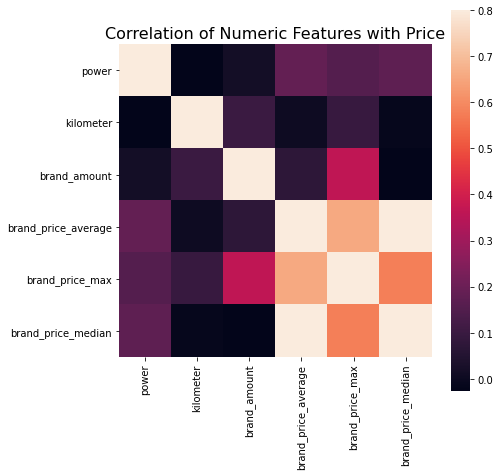

In [34]:
# 也可以直接看图
data_numeric=data[['power','kilometer','brand_amount','brand_price_average',
                  'brand_price_max','brand_price_median']]
correlation=data_numeric.corr()

f,ax=plt.subplots(figsize=(7,7))
plt.title('Correlation of Numeric Features with Price',y=1,size=16)
sns.heatmap(correlation,square=True,vmax=0.8)

#### 2)包裹式（install mlxtend）

In [43]:
#k_feature太大会很难跑，没服务器，所以提前断了
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
sfs=SFS(LinearRegression(),#以lr模型为例，评分为r2
       k_features=8,#从300多维的特征里选了10维的特征
       forward=True,
       floating=False,
       scoring='r2',
       cv=0)
x=data.drop(['price'],axis=1)
x=x.fillna(0)
y=data['price']
sfs.fit(x,y)
sfs.k_feature_names_
#是用贪心策略来做的

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [45]:
x['city'].isnull().sum()

0

In [38]:
# 看边际效益
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1=plot_sfs(sfs.get_metric_dict(),kind='std_dev')
plt.grid()
plt.show()

AttributeError: SequentialFeatureSelector has not been fitted, yet.

- 正常输出图，显示选出的10维特征和边际效益递增
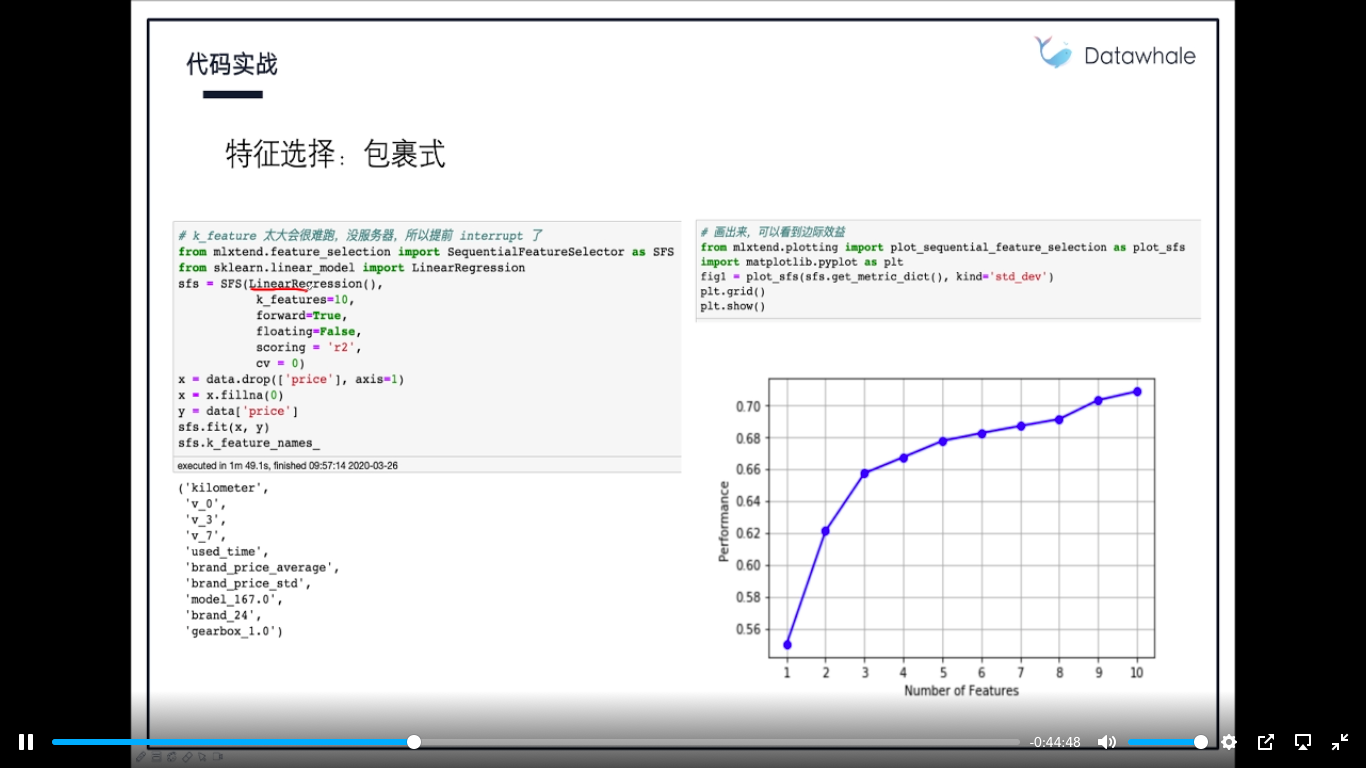


#### 4)嵌入式
- Lasso回归和决策树可以完成嵌入式特征选择
- 大部分时候用嵌入式做特征筛选

## 总结

- 特征工程的主要目的是在于将数据转换为能更好地表示潜在问题的特征，从而提高机器学习的性能。比如，异常值处理是为了去除噪声，填补缺失值可以加入先验知识
